In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [61]:
df = pd.read_csv("/work/app/data/input/filtered_result.csv")
df["伝票日付"] = pd.to_datetime(df["伝票日付"], format="%Y-%m-%d", errors="coerce")
df

,伝票日付,正味重量,品名
0,2020-01-06,470.0,混合廃棄物B
1,2020-01-06,390.0,その他
2,2020-01-06,120.0,混合廃棄物A
3,2020-01-06,1720.0,混合廃棄物B
4,2020-01-06,320.0,選別
...,...,...,...
210744,2025-05-26,350.0,混合廃棄物A
210745,2025-05-26,20.0,ﾀｲﾔ(ﾎｲﾙ無)
210746,2025-05-26,450.0,混合廃棄物A
210747,2025-05-26,430.0,混合廃棄物A


In [62]:
# === 必要なライブラリ ===
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import jpholiday
from lightgbm import early_stopping, log_evaluation

# === 補助関数 ===

# --- 祝日フラグ判定関数 ---
def make_holiday_flag(date):
    return int(jpholiday.is_holiday(date) or date.weekday() >= 5)

# --- 品目分類関数 ---
def classify_item(item: str) -> str:
    if "混合廃棄物A" in item:
        return "混合A"
    elif "混合廃棄物B" in item:
        return "混合B"
    else:
        return "その他"


## データ整理

In [63]:
# 祝日フラグの付与
df["祝日フラグ"] = df["伝票日付"].map(lambda x: int(jpholiday.is_holiday(x)))

# 曜日付与
df["曜日"] = df["伝票日付"].dt.dayofweek

# 祝日 or 日曜を除外（→ 土曜は残す）
# df = df[(df["祝日フラグ"] == 0) & (df["曜日"] != 6)].copy()

# 伝票日付単位で正味重量だけを sum → DataFrame に格納
df_daily_sum = df.groupby("伝票日付")["正味重量"].sum().reset_index()

# 5万kg以下の日付を除外
# df_daily_sum = df_daily_sum[df_daily_sum["正味重量"] >= 50000].copy()

# （確認用に表示）
print(f"✅ 残ったデータ件数: {len(df_daily_sum)}")
print(f"✅ 日付範囲: {df_daily_sum['伝票日付'].min()} 〜 {df_daily_sum['伝票日付'].max()}")


✅ 残ったデータ件数: 1473
✅ 日付範囲: 2020-01-06 00:00:00 〜 2025-05-26 00:00:00


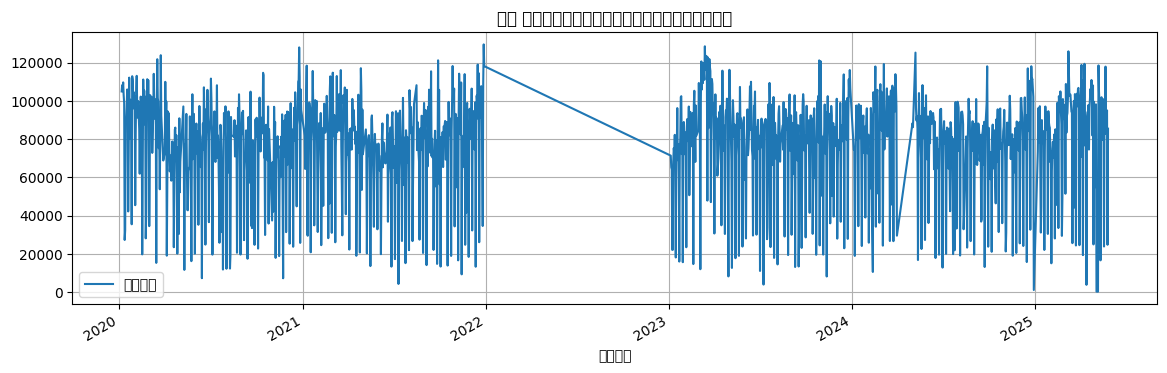

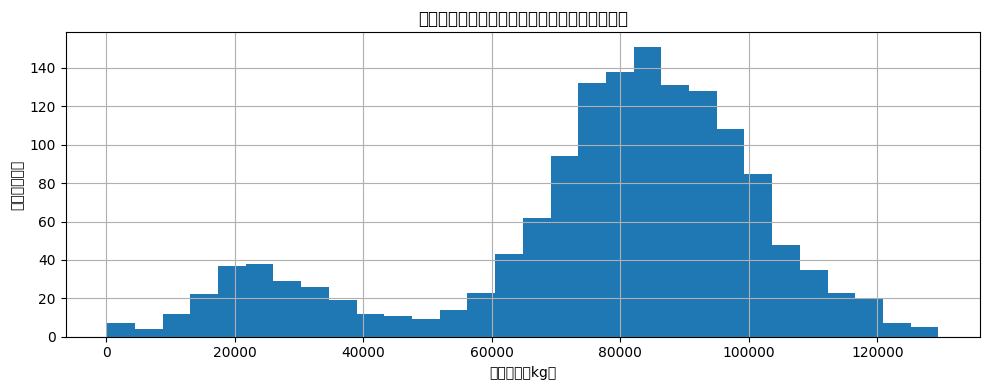

In [64]:

# 時系列で正味重量をプロット
df_daily_sum.plot(
    x="伝票日付",
    y="正味重量",
    figsize=(14, 4),
    title="日別 正味重量の推移（祝日・日曜除外、土曜含む）",
    grid=True
)
# ヒストグラムで正味重量の分布を確認
plt.figure(figsize=(10, 4))
df_daily_sum["正味重量"].hist(bins=30)
plt.title("正味重量の分布（祝日・日曜除外、土曜含む）")
plt.xlabel("正味重量（kg）")
plt.ylabel("日数（件数）")
plt.grid(True)
plt.tight_layout()
plt.show()


## 特徴量生成

In [65]:

def add_previous_year_feature(df_pivot: pd.DataFrame) -> pd.DataFrame:
    df_prev_year = df_pivot.copy()
    df_prev_year.index = df_prev_year.index + pd.DateOffset(years=1)
    df_prev_year_sum = df_prev_year.sum(axis=1).to_frame(name="前年同期重量")
    df_prev_year_sum = df_prev_year_sum.sort_index()

    # 元 df_pivot に merge して "前年同期重量" を列として追加した DataFrame を返す
    df_current = df_pivot.copy()
    df_current = df_current.sort_index()
    df_current = df_current.merge(
        df_prev_year_sum,
        how="left",
        left_index=True,
        right_index=True
    )

    df_current["前年同期重量"] = df_current["前年同期重量"].fillna(0)

    return df_current[["前年同期重量"]]


def compute_previous_year_ratio(df_pivot: pd.DataFrame) -> pd.DataFrame:
    # 前年同期重量
    df_prev_year_sum = add_previous_year_feature(df_pivot)

    # 全体平均搬入量（前年のみ）
    prev_year_dates = df_pivot.index - pd.DateOffset(years=1)
    mask_prev_year = df_pivot.index.isin(prev_year_dates)
    total_prev_year_weight = df_pivot.loc[mask_prev_year].sum(axis=1).mean()

    # 比率 = 前年同期重量 / 前年平均
    df_prev_year_sum["前年同期比率"] = df_prev_year_sum["前年同期重量"] / total_prev_year_weight
    df_prev_year_sum["前年同期比率"] = df_prev_year_sum["前年同期比率"].fillna(0)

    return df_prev_year_sum[["前年同期比率"]]


def add_holiday_adjacent_flag(dates: pd.Index) -> pd.Series:
    # 祝日フラグ（あなたの make_holiday_flag を使う）
    holiday_flags = dates.map(make_holiday_flag).astype(int)

    # 連休前後フラグ初期化
    adjacent_flags = np.zeros(len(dates), dtype=int)

    # ループで前後判定
    for i in range(1, len(dates) - 1):
        # 連休中なら1
        if holiday_flags[i] == 1:
            adjacent_flags[i] = 1
        # 連休前日
        elif holiday_flags[i - 1] == 1:
            adjacent_flags[i] = 1
        # 連休翌日
        elif holiday_flags[i + 1] == 1:
            adjacent_flags[i] = 1

    return pd.Series(adjacent_flags, index=dates, name="連休前後フラグ")

def add_month_start_end_flags(dates: pd.Index) -> pd.DataFrame:
    df = pd.DataFrame(index=dates)
    df["day"] = dates.day
    df["days_in_month"] = dates.days_in_month

    df["月初フラグ"] = (df["day"] <= 3).astype(int)
    df["月末フラグ"] = (df["days_in_month"] - df["day"] <= 2).astype(int)

    return df[["月初フラグ", "月末フラグ"]]


### 実関数

In [66]:
def prepare_features(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    df = df.copy()
    df["伝票日付"] = pd.to_datetime(df["伝票日付"])
    df["品目分類"] = df["品名"].apply(classify_item)

    df_daily = df.groupby(["伝票日付", "品目分類"])["正味重量"].sum().reset_index()
    df_pivot = df_daily.pivot(index="伝票日付", columns="品目分類", values="正味重量").fillna(0)
    df_pivot = df_pivot.sort_index()

    df_feat = df_pivot.copy()
    df_feat["曜日"] = df_feat.index.dayofweek
    df_feat["月"] = df_feat.index.month
    # df_feat["祝日フラグ"] = df_feat.index.map(make_holiday_flag)
    df_feat["前日合計"] = df_pivot.sum(axis=1).shift(1)

    for col in df_pivot.columns:
        df_feat[f"前日_{col}"] = df_pivot[col].shift(1)

    # --- 前年同期重量 merge ---
    df_feat = df_feat.merge(
        add_previous_year_feature(df_pivot),
        how="left",
        left_index=True,
        right_index=True
    )
    df_feat["前年同期重量"] = df_feat["前年同期重量"].fillna(0)

    # 月初／月末フラグ
    df_feat = df_feat.merge(
        add_month_start_end_flags(df_feat.index),
        how="left",
        left_index=True,
        right_index=True
    )

    # --- 連休前後フラグ（reset_index前に付ける！）---
    df_feat["連休前後フラグ"] = add_holiday_adjacent_flag(df_feat.index)

    # --- 目的変数（翌日合計重量）---
    df_feat["翌日合計"] = df_pivot.sum(axis=1).shift(-1)

    # --- 最後に dropna + reset_index ---
    df_feat = df_feat.dropna().reset_index()

    X = df_feat.drop(columns=["伝票日付", "翌日合計"])
    y = df_feat["翌日合計"]

    return X, y, df_feat

## モデル処理

In [67]:

# --- Fold単位の学習・評価 ---
def train_and_evaluate_fold(fold, X_train, X_test, y_train, y_test):
    # --- LightGBMデータセット ---
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    # --- パラメータ ---
    params = {
        "objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.05,
        "num_leaves": 31,
        "max_depth": 7,
        "min_data_in_leaf": 20,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
    }
    
    # --- 学習 ---
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        num_boost_round=2000,
        callbacks=[
            early_stopping(stopping_rounds=100),
            log_evaluation(period=100),
        ],
    )
    
    # --- 学習データ側の評価 ---
    y_train_pred = model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    
    # --- テストデータ側の評価 ---
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    
    # --- 結果表示 ---
    print(f"\n📂 Fold {fold+1}")
    print(f"📊 MAE:       {mae:.2f} kg")
    print(f"📊 Train R²:  {r2_train:.4f}")
    print(f"📊 Test  R²:  {r2_test:.4f}")
    
    return mae, r2_train, r2_test

# --- Fold平均結果出力 ---
def print_fold_summary(mae_list, r2_train_list, r2_test_list):
    print("\n✅ 全Fold平均MAE: {:.2f} kg".format(np.mean(mae_list)))
    print("✅ 全Fold平均Train R²: {:.4f}".format(np.mean(r2_train_list)))
    print("✅ 全Fold平均Test  R²: {:.4f}".format(np.mean(r2_test_list)))
    print("")


## メイン処理

In [68]:

# === メイン処理 ===

# --- データ読み込み（ここはあなたの元の df を用意しておく） ---
# 例: df = pd.read_csv("your_data.csv")
# 今回は既に df が定義済みとして進めます

X, y ,df_feat  = prepare_features(df)

# --- TimeSeriesSplit設定 ---
tscv = TimeSeriesSplit(n_splits=5)

# --- foldごとの評価用 ---
fold_mae_list = []
fold_r2_train_list = []
fold_r2_test_list = []

# --- モデルループ ---
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    mae, r2_train, r2_test = train_and_evaluate_fold(fold, X_train, X_test, y_train, y_test)
    
    fold_mae_list.append(mae)
    fold_r2_train_list.append(r2_train)
    fold_r2_test_list.append(r2_test)

# --- 結果まとめ表示 ---
print_fold_summary(fold_mae_list, fold_r2_train_list, fold_r2_test_list)


Training until validation scores don't improve for 100 rounds
[100]	training's l1: 8760.22	valid_1's l1: 13310.6
Early stopping, best iteration is:
[37]	training's l1: 11261.4	valid_1's l1: 12907.6

📂 Fold 1
📊 MAE:       12907.59 kg
📊 Train R²:  0.6498
📊 Test  R²:  0.4981
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 8220.92	valid_1's l1: 15328.2
Early stopping, best iteration is:
[52]	training's l1: 10011.7	valid_1's l1: 15049.3

📂 Fold 2
📊 MAE:       15049.25 kg
📊 Train R²:  0.6982
📊 Test  R²:  0.5117
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 8724.64	valid_1's l1: 13132.8
Early stopping, best iteration is:
[64]	training's l1: 9802.95	valid_1's l1: 12811.6

📂 Fold 3
📊 MAE:       12811.57 kg
📊 Train R²:  0.7291
📊 Test  R²:  0.5712
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 8658.21	valid_1's l1: 11805
Early stopping, best iteration is:
[85]	training's l1: 9028.19	valid_1

✅ データ件数: 1477
✅ 日付範囲: 2020-01-07 00:00:00 〜 2025-05-25 00:00:00

✅ 曜日ごとの件数（0=月曜、6=日曜）
曜日
0    213
1    212
2    216
3    214
4    218
5    215
6    189
Name: count, dtype: int64

✅ 翌日合計 describe():
count      1477.000000
mean      77006.371022
std       25613.628377
min         170.000000
25%       69200.000000
50%       82290.000000
75%       94060.000000
max      129520.000000
Name: 翌日合計, dtype: float64


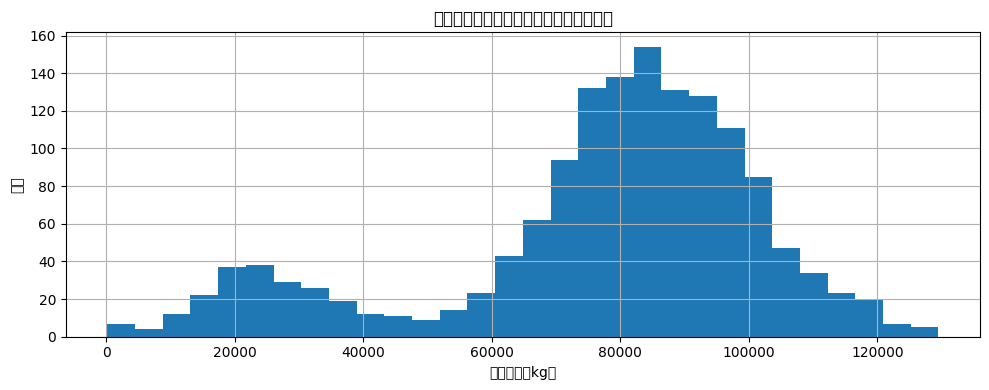

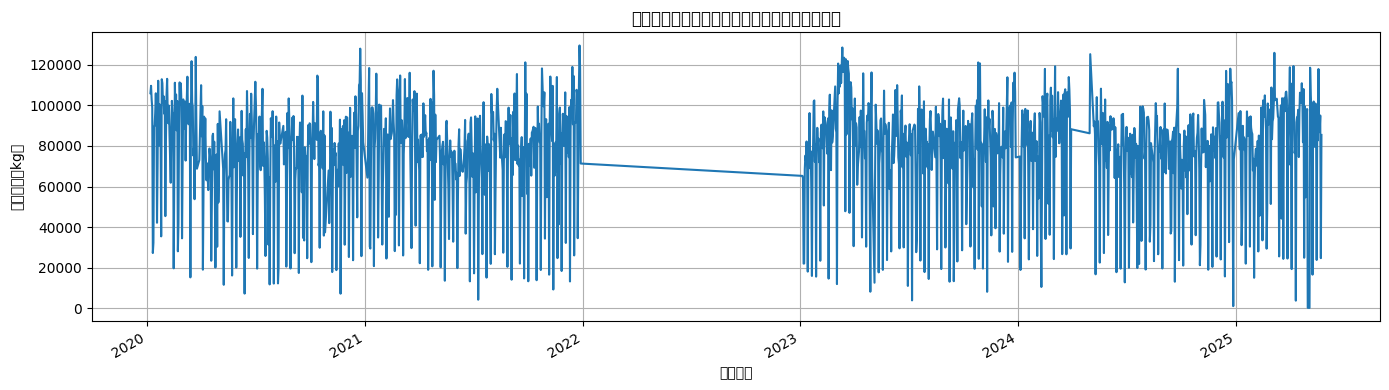

In [69]:
# === ① df_feat の件数確認 ===
print("✅ データ件数:", len(df_feat))
print("✅ 日付範囲:", df_feat["伝票日付"].min(), "〜", df_feat["伝票日付"].max())

# === ② 曜日ごとの件数確認 ===
print("\n✅ 曜日ごとの件数（0=月曜、6=日曜）")
print(df_feat["曜日"].value_counts().sort_index())

# === ③ 翌日合計の分布確認 ===
print("\n✅ 翌日合計 describe():")
print(df_feat["翌日合計"].describe())

# 翌日合計のヒストグラム（分布確認）
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
df_feat["翌日合計"].hist(bins=30)
plt.title("翌日合計の分布（休日・日曜カット後）")
plt.xlabel("翌日合計（kg）")
plt.ylabel("件数")
plt.grid(True)
plt.tight_layout()
plt.show()

# === ④ 搬入量（翌日合計） vs 日付の推移（時系列確認） ===
df_feat.set_index("伝票日付")["翌日合計"].plot(figsize=(14, 4), title="翌日合計の時系列推移（休日・日曜カット後）", grid=True)
plt.ylabel("翌日合計（kg）")
plt.tight_layout()
plt.show()
